# 04b-pois_time_for_unique_IDs

This notebook loads specific points (already filtered and classified for a given source of interest in Notebooks starting with 03 or externally) and a source_name, calculates and loads into database the time from each node in Santiago, Chile to its closest pois using function analysis>pois_time() as well as the amount of amenities at a 15 minute walk from each node (count_pois = (True,15)).

__Different to Notebook 04-pois_time_to_db and Script 23-proximity-analysis-progressive.py:__ This notebook allows us to include a unique ID inside pois to take into consideration geometry of origin. (For more information, visit analysis.py function id_pois_time)

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Main Function

In [2]:
def main(source_list, aoi, nodes, edges, G, walking_speed, local_save=False, save=False):
    ############################################################### PART 1 ###############################################################
    #################################################### FIND NODES PROXIMITY TO POIS ####################################################
    
    # 1.1 --------------- NODES PROXIMITY TO POIS
    # ------------------- This step loads each source of interest, calculates nodes proximity and saves to database
    k = len(source_list)
    i = 1
    for source in source_list:
        print('--'*40)
        print(f"--- STARTING nodes proximity to pois using speed {walking_speed}km/hr for source {i}/{k}: {source}.")
    
        # 1.1a) Read pois from pois dir
        print(f"--- Reading pois dir.")
        # Directory where pois to be examined are located
        pois_dir = gral_dir + f'{source}.gpkg'
        # Load all pois from directory
        pois = gpd.read_file(pois_dir)
        # Format
        pois = pois[['ID','geometry']]
        pois = pois.set_crs("EPSG:4326")
        
        # 1.1b) Clip pois to aoi
        source_pois = gpd.sjoin(pois, aoi)
        source_pois = source_pois[['ID','geometry']]
        print(f"--- Keeping {len(source_pois)} pois inside aoi from original {len(pois)} pois.")
        
        if save_space:
            del pois
    
        # 1.1c) Calculate nodes proximity (Function pois_time())
        print(f"--- Calculating nodes proximity.")
        source_nodes_time = aup.id_pois_time(G, nodes, edges, source_pois, source, 'length', walking_speed, 
                                             goi_id='ID', count_pois=count_pois, projected_crs=projected_crs)
        source_nodes_time.rename(columns={'time_'+source:source},inplace=True)
        nodes_analysis = source_nodes_time.copy()
    
        if save_space:
            del source_pois
            del source_nodes_time
        
        # 1.1d) Nodes_analysis format
        # if count_pois, include generated col
        if count_pois[0]:
            column_order = ['osmid'] + [source, f'{source}_{count_pois[1]}min'] + ['x','y','geometry']
        else:
            column_order = ['osmid'] + [source] + ['x','y','geometry']
        nodes_analysis = nodes_analysis[column_order]
        print(f"--- FINISHED source {source}. Mean city time = {nodes_analysis[source].mean()}")
        
        # 1.1e) Tidy data format (Allows loop-upload)
        print(f"--- Reordering datased as tidy data format.")
        # Add source column to be able to extract source proximity data. Fill with current source.
        nodes_analysis['source'] = source
        # Rename source-specific column names as name that apply to all sources (source_time, source_15min)
        nodes_analysis.rename(columns={source:'source_time'},inplace=True)
        if count_pois[0]:
            nodes_analysis.rename(columns={f'{source}_{count_pois[1]}min':'source_15min'},inplace=True)
        # Set column order
        if count_pois[0]:
            nodes_analysis = nodes_analysis[['osmid','source','source_time','source_15min','x','y','geometry']]
        else:
            nodes_analysis = nodes_analysis[['osmid','source','source_time','x','y','geometry']]
        # Add city data
        nodes_analysis['city'] = city
       
        # 1.1f) Save output
        if save:
            aup.gdf_to_db_slow(nodes_analysis, nodes_save_table, save_schema, if_exists='append')
            print(f"--- Saved nodes proximity to {source} in database.")
        
        if local_save:
            nodes_analysis.to_file(nodes_local_save_dir, driver='GPKG')
            print(f"--- Saved nodes proximity to {source} locally.")
    
        if save_space:
            del nodes_analysis
            print(f"--- Deleted current {source} nodes analysis to save space.")
    
        print(f"--- FINISHED nodes proximity to pois using speed {walking_speed}km/hr for source {i}/{k}: {source}.")
        i+=1

## Script outisde main function

In [ ]:
print('--'*50)
print('--- STARTING SCRIPT 23 [MODIFIED].')

# ------------------------------ BASE DATA REQUIRED ------------------------------
# general pois local dir
gral_dir = '../../../data/external/temporal_fromjupyter/santiago/pois/'

# List of pois to be examined.
# This list should contain the source_name that will be assigned to each processed poi.
# That source_name will be stored in a 'source' column at first and be turned into a column name after all pois are processed.
# That source_name must also be the name of the file stored in gral_dir (.gpkg)
source_list = ['ferias','ep_plaza_big'] #'ep_plaza_small' has +9000 unique IDs!!!!! skipped for now 

# Pois proximity methodology - Count pois at a given time proximity?
count_pois = (True,15)

# walking_speed (float): Decimal number containing walking speed (in km/hr) to be used if prox_measure="length",
#						 or if prox_measure="time_min" but needing to fill time_min NaNs.
walking_speed_list = [4.5,5,12,24,20,40] #3.5

# Area of interest (Run 'AM_Santiago', it represents Santiago's metropolitan area. We can clip data as soon as we know inputs extent.)
city = 'AM_Santiago'

# goi_id (str): Text containing name of column with unique ID for the geometry of interest from which pois where created.
goi_id = 'ID'

# Save space in disk by deleting data that won't be used again?
save_space = True

##### WARNING ##### WARNING ##### WARNING #####
save = True # save output to database?
local_save = False # save output to local? (Make sure directory exists)
nodes_local_save_dir = f"../../../data/processed/santiago/santiago_nodesproximity.gpkg"
##### WARNING ##### WARNING ##### WARNING #####

# ------------------------------ SCRIPT CONFIGURATION - DATABASE SCHEMAS AND TABLES ------------------------------

# Area of interest (aoi)
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
# OSMnx Network
network_schema = 'projects_research'
edges_table = 'santiago_edges'
nodes_table = 'santiago_nodes'
projected_crs = 'EPSG:32719'
# Save output to db
save_schema = 'projects_research'

# ------------------------------ SCRIPT START ------------------------------

# 1.1 --------------- BASE DATA FOR POIS-NODES ANALYSIS
# ------------------- This step downloads the area of interest and network used to measure distance.

# Area of interest (aoi)
print("--- Downloading area of interest.")
#query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
#aoi = aup.gdf_from_query(query, geometry_col='geometry')
#aoi = aoi.set_crs("EPSG:4326")

# OSMnx Network
print("--- Downloading network.")
#G, nodes, edges = aup.graph_from_hippo(aoi, network_schema, edges_table, nodes_table, projected_crs)

# Start Main function
for walking_speed in walking_speed_list:
    print('--'*45)
    print(f"--- Running Script [Modified] for verified sources for speed = {walking_speed}km/hr.")
    str_walking_speed = str(walking_speed).replace('.','_')
    nodes_save_table = f'santiago_nodesproximity_{str_walking_speed}_kmh'

    if save:
        # Saved sources check (prevents us from uploading same source twice/errors on source list)
        print(f"--- Verifying sources by comparing to data already uploaded.")
        try:
            # Load sources already processed
            query = f"SELECT DISTINCT source FROM {save_schema}.{nodes_save_table}"
            saved_data = aup.df_from_query(query)
            saved_sources = list(saved_data.source.unique())
            if save_space:
                del saved_data
        except:
            saved_sources = []
            print(f"--- No data found for {nodes_save_table}.")
        
        # Verify current source list
        for source in source_list:
            if source in saved_sources:
                print(f"--- ERROR: Source {source} already processed and in database.")
                print(f"--- Remove source from dataset or change source_name before continuing.")
                break
                # intended_crash
        
    # If passed source check, proceed to main function
    print(f"--- Running Script for verified sources.")
    main(source_list, aoi, nodes, edges, G, walking_speed, local_save, save)

----------------------------------------------------------------------------------------------------
--- STARTING SCRIPT 23 [MODIFIED].
--- Downloading area of interest.
--- Downloading network.
--- Running Script [Modified] for verified sources for speed = 4.5km/hr.
--- Verifying sources by comparing to data already uploaded.
--- No data found for santiago_nodesproximity_4_5_kmh.
--- Running Script for verified sources.
--------------------------------------------------------------------------------
--- STARTING nodes proximity to pois using speed 4.5km/hr for source 1/2: ferias.
--- Reading pois dir.
--- Keeping 1855 pois inside aoi from original 1855 pois.
--- Calculating nodes proximity.
Found and assigned nearest node osmid to each ferias.
Calculated length for 0 edges that had no length data.
Starting time analysis for ferias.
Calculating proximity data for geometry of interest (goi) 1 of 433 for ferias.
0% done.
First geometry of interest (goi)'s time.
First batch count.
Calcula

## Building (Step by step of code that's above this markdown)

### Building main function (Basically Script 23, step by step)

In [3]:
############################################################### PART 1 ###############################################################
#################################################### FIND NODES PROXIMITY TO POIS ####################################################

<Axes: >

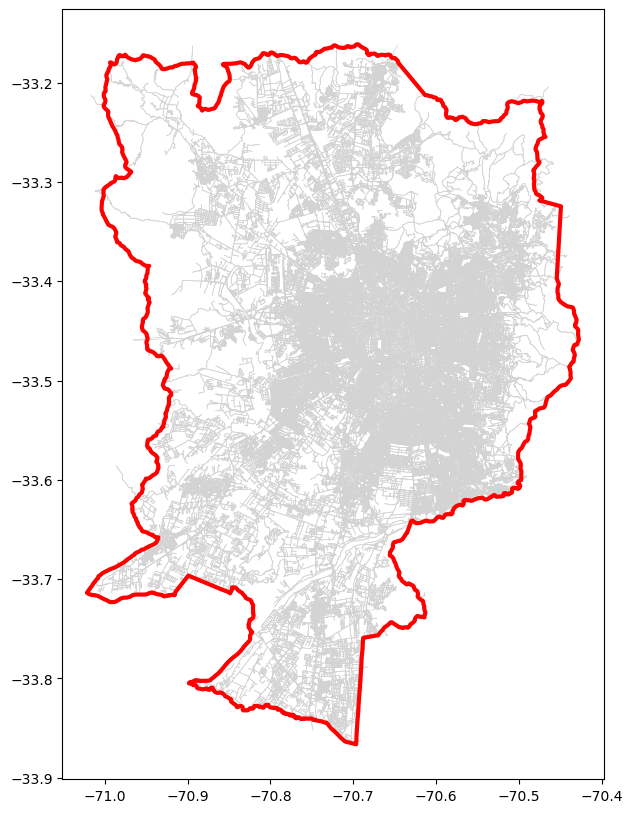

In [4]:
# 1.1 --------------- BASE DATA FOR POIS-NODES ANALYSIS
# ------------------- This step downloads the area of interest and network used to measure distance.

# Area of interest (aoi)
aup.log("--- Downloading area of interest.")
query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# OSMnx Network
aup.log("--- Downloading network.")
G, nodes, edges = aup.graph_from_hippo(aoi, network_schema, edges_table, nodes_table, projected_crs)

# Show
fig,ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

#### __From here on, will go inside for loop__

In [7]:
# 1.1 --------------- NODES PROXIMITY TO POIS
# ------------------- This step loads each source of interest, calculates nodes proximity and saves to database
#k = len(source_list)
#i = 1

#for source in source_list:
    # print(f"--- Starting nodes proximity to pois for source {i}/{k}: {source}. ")

In [11]:
source = source_list[0]

# 1.1a) Read pois from pois dir
print(f"--- Reading pois dir.")
# Directory where pois to be examined are located
pois_dir = gral_dir + f'{source}.gpkg'
# Load all pois from directory
pois = gpd.read_file(pois_dir)
# Format
pois = pois[['ID','geometry']]
pois = pois.set_crs("EPSG:4326")

# 1.1b) Clip pois to aoi
source_pois = gpd.sjoin(pois, aoi)
source_pois = source_pois[['ID','geometry']]
source_pois.rename(columns={'ID':'goi_id'},inplace=True)
print(f"--- Keeping {len(source_pois)} pois inside aoi from original {len(pois)} pois.")

if save_space:
    del pois

# Show
print(source_pois.shape)
source_pois.head(1)

--- Reading pois dir.
--- Keeping 1855 pois inside aoi from original 1855 pois.
(1855, 2)


,goi_id,geometry
0,1,POINT (-70.86039 -33.81210)


In [46]:
####################################################################################################################################
# 1.3b ADAPTATION
# Whenever pois are extracted from other types of geometries or interest (gois) (e.g. lines, polygons), a unique ID should be assigned.
# That's because when measuring how many pois (count_pois) there are, we want to know access to one goi (e.g. one bike lane or one park),
# not measure how many points belonging to the same goi exist.

# Since one goi has several pois, any osmnx node could get assigned several pois even if they all belong to the same goi.
# Therefore, we cannot use function analysis/pois_time().
# This step unfolds function analysis/pois_time() so that if the previous case happens, the node gets assigned to the closest poi of the goi only. (Once)
####################################################################################################################################

# 1.3 --------------- ANALYSE POINTS OF INTEREST
# ------------------- This step analysis times (and count of pois at given time proximity if requested) 
# ------------------- using contents of function analysis/pois_time().

# PREP. FOR ANALYSIS
i = 0
# PREP. FOR ANALYSIS - List of columns used to deliver final format
analysis_cols = []

analysis_cols.append(source)
if count_pois[0]:
    count_col = f'{source}_{count_pois[1]}min'
    analysis_cols.append(count_col)

# ANALYSIS - Calculate time data from nodes to source
####################################################################################################################################################################################
# FROM FUNCTION analysis/pois_time():
# Calculates times from nodes to source (source_nodes_time = aup.pois_time(G, nodes, edges, source_pois, source, prox_measure,count_pois))
# analysis function being used: def pois_time(G, nodes, edges, pois, poi_name, prox_measure,count_pois=(False,0)):
pois = source_pois.copy()
poi_name = source
prox_measure = 'length'
##########################################################################################
# STEP 1: NEAREST.

# Finds and assigns nearest node OSMID to each point of interest.
   
# Defines projection for downloaded data
pois = pois.set_crs("EPSG:4326")
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

# In case there are no amenities of the type in the city, prevents it from crashing if len = 0
if len(pois) == 0:
    nodes_time = nodes.copy()

    # Format
    nodes_time.reset_index(inplace=True)
    nodes_time = nodes_time.set_crs("EPSG:4326")

    # As no amenities were found, output columns are set to nan.
    nodes_time['time_'+poi_name] = np.nan # Time is set to np.nan.
    print(f"0 {poi_name} found. Time set to np.nan for all nodes.")
    if count_pois[0]: 
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = np.nan # If requested pois_count, value is set to np.nan.
        print(f"0 {poi_name} found. Pois count set to nan for all nodes.")
        nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
        #return nodes_time
    else:
        nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]
        #return nodes_time

else:
    ### Find nearest osmnx node for each DENUE point.
    nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
    nearest = nearest.set_crs("EPSG:4326")
    print(f"Found and assigned nearest node osmid to each {poi_name}.")

##########################################################################################
# ADDITIONAL STEP RELEVANT FOR POIS THAT HAVE IDs
# Up to this point 'nearest' has all osmnx nodes closest to a given poi from a given goi, 
# one osmnx node might be assigned to 2 or more goi poi of the SAME goi. 
# (For example, node 54 is closest to poi 12 and poi 13, both from the geometry of interest 5).

# If we leave it like that, that node will count as n points of interest even if it is just close to 1 goi.
# This step keeps the minimum distance (distance_node) from node osmid to each goi poi, 
# so that if one node is close to 5 pois of 1 goi, it keeps only 1 row poi, not 5.

# Group by node (osmid) and polygon (green space) considering only the closest vertex (min)
groupby = nearest.groupby(['osmid','goi_id']).agg({'distance_node':np.min})

# Turns back into gdf merging back with nodes geometry
geom_gdf = nodes.reset_index()[['osmid','geometry']]

groupby.reset_index(inplace=True)
nearest = pd.merge(groupby,geom_gdf,on='osmid',how='left')
nearest = gpd.GeoDataFrame(nearest, geometry="geometry")

# Filters for pois assigned to nodes at a maximum distance of 80 meters (aprox. 1 minute)
# That is to consider a 1 minute additional walk as acceptable (if goi is inside a park, e.g. a bike lane).
nearest = nearest.loc[nearest.distance_node <= 80]

##########################################################################################
# STEP 2: DISTANCE NEAREST POI. 
# Calculates distance from each node to its nearest point of interest using previously assigned nearest node.

# 2.1 --------------- FORMAT NETWORK DATA
# Fill NANs in length with calculated length (prevents crash)
no_length = len(edges.loc[edges['length'].isna()])
edges = edges.to_crs(projected_crs)
edges['length'].fillna(edges.length,inplace=True)
edges = edges.to_crs("EPSG:4326")
print(f"Calculated length for {no_length} edges that had no length data.")

# If prox_measure = 'length', calculates time_min assuming walking speed = 4km/hr
if prox_measure == 'length':
    edges['time_min'] = (edges['length']*60)/4000
else:
    # NaNs in time_min? --> Assume walking speed = 4km/hr
    no_time = len(edges.loc[edges['time_min'].isna()])
    edges['time_min'].fillna((edges['length']*60)/4000,inplace=True)
    print(f"Calculated time for {no_time} edges that had no time data.")

# --------------- 2.2 ELEMENTS NEEDED OUTSIDE THE ANALYSIS LOOP
# The pois are divided by batches of 200 or 250 pois and analysed using the function calculate_distance_nearest_poi.
# nodes_analysis is a nodes gdf (index reseted) used in the function aup.calculate_distance_nearest_poi.
nodes_analysis = nodes.reset_index().copy()
# nodes_time: int_gdf stores, processes time data within the loop and returns final gdf. (df_int, df_temp, df_min and nodes_distance in previous code versions)
nodes_time = nodes.copy()

# --------------- 2.3 PROCESSING DISTANCE
print (f"Starting time analysis for {poi_name}.")

##########################################################################################
# ADAPTATION
# Now, for each node, the code might find in OSMnx Network n (e.g. 5) close nearest nodes (Nodes closest to pois) belonging to the same geometry of interest (goi).
# What's desired is to know, for each node, closest proximity to geometry of interest (goi).
# This modified step iterates over goi_id so that when a node finds n close pois of the same geometry of interest (goi) (using pois_count), it only gets assigned '1'.
# (As it is the same geometry of interest, goi)
##########################################################################################

gois_list = list(nearest['goi_id'].unique())

g = 1
for goi in gois_list:
    print(f"Starting geometry of interest {g} of {len(gois_list)} for {poi_name}.")

    # Calculate
    source_process = nearest.loc[nearest.goi_id == goi]
    nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, poi_name, 'osmid', wght='time_min',count_pois=count_pois)

    # Extract from nodes_distance_prep the calculated time data
    process_time_col = 'time_process_'+poi_name
    nodes_time[process_time_col] = nodes_distance_prep['dist_'+poi_name]

    # If requested, extract from nodes_distance_prep the calculated pois count
    if count_pois[0]:
        process_poiscount_col = f'{poi_name}_process_{count_pois[1]}min'
        nodes_time[process_poiscount_col] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']
        
        ##########################################################################################
        # ADAPTATION
        # Since we are only analysing one geometry of interest (goi), no node should have more than one pois count. (No node should've found two gois)
        # If count>0, set to 1
        
        tmp_poiscount_col = f'{poi_name}_tmp_{count_pois[1]}min'
        nodes_time[tmp_poiscount_col] = nodes_time[process_poiscount_col].apply(lambda x: 1 if x > 0 else 0)
        nodes_time[process_poiscount_col] = nodes_time[tmp_poiscount_col]
        nodes_time.drop(columns=[tmp_poiscount_col],inplace=True)

        ##########################################################################################
    
    # After this batch's processing is over, choose final value:
    
    # FOR TIME DATA:
    # If it is the first batch, assign first batch time
    if g == 1:
        print(f"First batch time.")
        nodes_time['time_'+poi_name] = nodes_time[process_time_col]
    # Else, apply the min function to find the minimum time so far
    else:
        time_cols = ['time_'+poi_name, process_time_col]
        nodes_time['time_'+poi_name] = nodes_time[time_cols].min(axis=1)

    # FOR COUNT DATA (If requested)
    # If it is the first batch, assign first batch count
    if g == 1:
        print(f"First batch count.")
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[process_poiscount_col]
    # Else, apply the sum function to find the total count so far
    else:
        count_cols = [f'{poi_name}_{count_pois[1]}min', process_poiscount_col]
        nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[count_cols].sum(axis=1)

    g = g+1

print(f"Finished time analysis for {poi_name}.")

##########################################################################################
# Step 3: FINAL FORMAT. Organices and filters output data.
nodes_time.reset_index(inplace=True)
nodes_time = nodes_time.set_crs("EPSG:4326")
if count_pois[0]:
    nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
    #return nodes_time
else:
    nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]		
    #return nodes_time

####################################################################################################################################################################################
# FINISHES FUNCTION aup.pois_time
source_nodes_time = nodes_time.copy()
####################################################################################################################################################################################

source_nodes_time.rename(columns={'time_'+source:source},inplace=True)
if count_pois[0]:
    source_nodes_time = source_nodes_time[['osmid',source,count_col,'x','y','geometry']]
else:
    source_nodes_time = source_nodes_time[['osmid',source,'x','y','geometry']]

# ANALYSIS - Merge all times in one df
if i == 0: # For the first analysed source
    nodes_analysis = source_nodes_time.copy()
else: # For the rest
    if count_pois[0]:
        nodes_analysis = pd.merge(nodes_analysis,source_nodes_time[['osmid',source,count_col]],on='osmid')
    else:
        nodes_analysis = pd.merge(nodes_analysis,source_nodes_time[['osmid',source]],on='osmid')

i = i+1

print(f"--- FINISHED source {source}. Mean city time = {nodes_analysis[source].mean()}")
        
# Final format for nodes
column_order = ['osmid'] + analysis_cols + ['x','y','geometry']
nodes_analysis_2 = nodes_analysis[column_order]

print(f"""FINISHED source pois proximity to nodes analysis for {city}.""")

# Show
print(nodes_analysis_2.shape)
nodes_analysis_2.head(1)

Found and assigned nearest node osmid to each ferias.
Calculated length for 0 edges that had no length data.
Starting time analysis for ferias.
Starting geometry of interest 1 of 433 for ferias.
First batch time.
First batch count.
Starting geometry of interest 2 of 433 for ferias.
Starting geometry of interest 3 of 433 for ferias.
Starting geometry of interest 4 of 433 for ferias.
Starting geometry of interest 5 of 433 for ferias.
Starting geometry of interest 6 of 433 for ferias.
Starting geometry of interest 7 of 433 for ferias.
Starting geometry of interest 8 of 433 for ferias.
Starting geometry of interest 9 of 433 for ferias.
Starting geometry of interest 10 of 433 for ferias.
Starting geometry of interest 11 of 433 for ferias.
Starting geometry of interest 12 of 433 for ferias.
Starting geometry of interest 13 of 433 for ferias.
Starting geometry of interest 14 of 433 for ferias.
Starting geometry of interest 15 of 433 for ferias.
Starting geometry of interest 16 of 433 for feri

,osmid,ferias,ferias_15min,x,y,geometry
0,386138,19.302675,0,-70.646254,-33.442901,POINT (-70.64625 -33.44290)


In [51]:
del nodes_analysis
nodes_analysis = nodes_analysis_2.copy()

# 1.1e) Tidy data format (Allows loop-upload)
print(f"--- Reordering datased as tidy data format.")
# Add source column to be able to extract source proximity data. Fill with current source.
nodes_analysis['source'] = source
# Rename source-specific column names as name that apply to all sources (source_time, source_15min)
nodes_analysis.rename(columns={source:'source_time'},inplace=True)
if count_pois[0]:
    nodes_analysis.rename(columns={f'{source}_{count_pois[1]}min':'source_15min'},inplace=True)
# Set column order
if count_pois[0]:
    nodes_analysis = nodes_analysis[['osmid','source','source_time','source_15min','x','y','geometry']]
else:
    nodes_analysis = nodes_analysis[['osmid','source','source_time','x','y','geometry']]
# Add city data
nodes_analysis['city'] = city

# Show
print(nodes_analysis.shape)
nodes_analysis.head(1)

--- Reordering datased as tidy data format.
(257999, 8)


,osmid,source,source_time,source_15min,x,y,geometry,city
0,386138,ferias,19.302675,0,-70.646254,-33.442901,POINT (-70.64625 -33.44290),AM_Santiago


In [62]:
# 1.1f) Save output
if save:
    aup.gdf_to_db_slow(nodes_analysis, nodes_save_table, save_schema, if_exists='append')
    print(f"--- Saved nodes proximity to {source} in database.")

if local_save:
    nodes_analysis.to_file(nodes_local_save_dir, driver='GPKG')
    print(f"--- Saved nodes proximity to {source} locally.")

if save_space:
    del nodes_analysis
    print(f"--- Deleted current {source} nodes analysis to save space.")

--- Saved nodes proximity to ferias in database.
--- Deleted current ferias nodes analysis to save space.


### Building function id_pois_time (Now available in analysis.py)

In [75]:
def id_pois_time(G, nodes, edges, pois, poi_name, prox_measure, goi_id, count_pois=(False,0), walking_speed=4, projected_crs="EPSG:6372"):
	""" Finds time from each node to nearest poi (point of interest) taking into account the original ID of origin of that poi.
        [Uses a geometry of interest (goi)'s unique ID to differenciate between gois].
	Args:
		G (networkx.MultiDiGraph): Graph with edge bearing attributes
		nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes within boundaries
		edges (geopandas.GeoDataFrame): GeoDataFrame with edges within boundaries
		pois (geopandas.GeoDataFrame): GeoDataFrame with points of interest
		poi_name (str): Text containing name of the point of interest being analysed
		prox_measure (str): Text ("length" or "time_min") used to choose a way to 
							calculate time between nodes and points of interest.
							If "length", will use walking speed.
							If "time_min", edges with time information must be provided.
        goi_id (str): Text containing name of column with unique ID for the geometry of interest from which pois where created.
        walking_speed (float, optional): Decimal number containing walking speed (in km/hr) to be used if prox_measure = "length". Defaults to 4.
		count_pois (tuple, optional): tuple containing boolean to find number of pois within given time proximity. Defaults to (False, 0)
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".
    
	Returns:
		geopandas.GeoDataFrame: GeoDataFrame with nodes containing time to nearest source (s).
	"""
    # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # DIFFERENCES WITH POIS_TIME() EXPLANATION:
    # Whenever pois are extracted from other types of geometries or interest (gois) (e.g. lines, polygons), a unique ID could be assigned.
    # That's because when we want to find access to one geometry of interest (goi) (e.g. one bike lane or one park), we consider that geometry as one,
    # and do not want to measure access to ALL pois that we created from that geometry of interest. 
    # (e.g. the vertexes of a park or a point every 100 meters for a bike lane)
    # (Which would happen without this ADAPTATION of function pois_time()).
    
    # Since one geometry of interest (goi) has several pois (e.g. extracted parks vertices or divided a bike lane in several points),
    # any OSMnx node would get assigned (nearest function) several pois even if they all belong to the same geometry of interest (goi).
    # Therefore, for that result, we cannot use function analysis/pois_time() without ADAPTATION.
    
    # The first main adaptation works so that after nearest function, a given node gets assigned to the closest poi of 
    # the geometry of interest (goi) only (Considers a given geometry of interest (goi) once and discard the rest).
    
    # The second main adaptation works so that proximity is measured for each geometry of interest (goi) and data is not repeated.
    
    # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # FOLLOWING SECTION OF POIS_TIME() HAS NO CHANGES
    
    ##########################################################################################
    # STEP 1: NEAREST.
    # Finds and assigns nearest node OSMID to each point of interest.
     
    # Defines projection for downloaded data
	pois = pois.set_crs("EPSG:4326")
	nodes = nodes.set_crs("EPSG:4326")
	edges = edges.set_crs("EPSG:4326")
    
    # In case there are no amenities of the type in the city, prevents it from crashing if len = 0
	if len(pois) == 0:
		nodes_time = nodes.copy()
    
        # Format
		nodes_time.reset_index(inplace=True)
		nodes_time = nodes_time.set_crs("EPSG:4326")
    
        # As no amenities were found, output columns are set to nan.
		nodes_time['time_'+poi_name] = np.nan # Time is set to np.nan.
		print(f"0 {poi_name} found. Time set to np.nan for all nodes.")
		if count_pois[0]: 
			nodes_time[f'{poi_name}_{count_pois[1]}min'] = np.nan # If requested pois_count, value is set to np.nan.
			print(f"0 {poi_name} found. Pois count set to nan for all nodes.")
			nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
			return nodes_time
		else:
			nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]
			return nodes_time
	else:
        ### Find nearest osmnx node for each DENUE point.
		nearest = aup.find_nearest(G, nodes, pois, return_distance= True)
		nearest = nearest.set_crs("EPSG:4326")
		print(f"Found and assigned nearest node osmid to each {poi_name}.")
    
    # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # ADAPTATION - FOLLOWING SECTION DOES NOT EXIST IN POIS_TIME()
        
        # Up to this point 'nearest' has all osmnx nodes closest to a given poi (Originated from a given geometry of interest (goi)), 
        # one osmnx node might be assigned to 2 or more poi of the SAME geometry of interest (goi). 
        # (For example, node 54 is closest to poi 12 and poi 13, both vertexes from the same park).
        
        # If we leave it like that, that nearest will be repeted (e.g. the same park assigned twice to the same node) even if it is just close to 1 goi.
        # This step keeps the minimum distance (distance_node) from node osmid to each poi when originating from the same geometry of interest (goi), 
        # so that if one node is close to 5 pois of the same goi, it keeps only 1 node assigned to 1 poi, not 5.
        
        # Group by node (osmid) and polygon (green space) considering only the closest vertex (min)
		groupby = nearest.groupby(['osmid',goi_id]).agg({'distance_node':np.min})
        
        # Turns back into gdf merging back with nodes geometry
		geom_gdf = nodes.reset_index()[['osmid','geometry']]
		groupby.reset_index(inplace=True)
		nearest = pd.merge(groupby,geom_gdf,on='osmid',how='left')
		nearest = gpd.GeoDataFrame(nearest, geometry="geometry")
        
        # Filters for pois assigned to nodes at a maximum distance of 80 meters (aprox. 1 minute)
        # That is to consider a 1 minute additional walk as acceptable (if goi is inside a park, e.g. a bike lane).
		nearest = nearest.loc[nearest.distance_node <= 80]
        
    # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # FOLLOWING SECTION OF POIS_TIME() HAS NO CHANGES

        ##########################################################################################
        # STEP 2: DISTANCE NEAREST POI. 
        # Calculates distance from each node to its nearest point of interest using previously assigned nearest node.
        
        # 2.1 --------------- FORMAT NETWORK DATA
        # Fill NANs in length with calculated length (prevents crash)
		no_length = len(edges.loc[edges['length'].isna()])
		edges = edges.to_crs(projected_crs)
		edges['length'].fillna(edges.length,inplace=True)
		edges = edges.to_crs("EPSG:4326")
		print(f"Calculated length for {no_length} edges that had no length data.")
        
        # If prox_measure = 'length', calculates time_min using walking_speed
		if prox_measure == 'length':
			edges['time_min'] = (edges['length']*60)/(walking_speed*1000)
		else:
            # NaNs in time_min? --> Use walking_speed
			no_time = len(edges.loc[edges['time_min'].isna()])
			edges['time_min'].fillna((edges['length']*60)/(walking_speed*1000),inplace=True)
			print(f"Calculated time for {no_time} edges that had no time data.")
        
        # --------------- 2.2 ELEMENTS NEEDED OUTSIDE THE ANALYSIS LOOP
        # The pois are divided by batches of 200 or 250 pois and analysed using the function calculate_distance_nearest_poi.
        # nodes_analysis is a nodes gdf (index reseted) used in the function aup.calculate_distance_nearest_poi.
		nodes_analysis = nodes.reset_index().copy()
        # nodes_time: int_gdf stores, processes time data within the loop and returns final gdf. (df_int, df_temp, df_min and nodes_distance in previous code versions)
		nodes_time = nodes.copy()
        
        # --------------- 2.3 PROCESSING DISTANCE
		print (f"Starting time analysis for {poi_name}.")
        
    # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # ADAPTATION - FOLLOWING SECTION IS DIFFERENT IN POIS_TIME()
    
    # At this point pois are in the network, pois are located in nearest.
    # But without ADAPTATION, for each node being analysed we might find in OSMnx Network many (e.g. 5) pois (nearest nodes) belonging to the same geometry of interest (goi).
    # For example, a node close to a park might find different 5 nodes where the park is near. But it is the same park!
    # We need to know, for each node, closest proximity to geometry of interest (goi).
    
    # This modified step iterates over goi_id so that when a node finds n close pois of the same geometry of interest (goi) (using pois_count), 
    # it only gets assigned '1' (As we iterate over goi_id, no matter how many times we calculate proximity to nearest, it is the same geometry of interest
    # (goi), it is the same park).
	
		gois_list = list(nearest[goi_id].unique())
		g = 1
		for goi in gois_list:
			print(f"Starting geometry of interest {g} of {len(gois_list)} for {poi_name}.")
        
            # Calculate
            # ADAPTATION - Dividing by batches of n pois is not necessary, since we will be examining batches of a small number of pois
            # (The pois belonging to a specific geometry of interest (goi)). 
            # (e.g. all source_process will be the nodes closest to the vertexes of 1 park)
			source_process = nearest.loc[nearest[goi_id] == goi]
			nodes_distance_prep = aup.calculate_distance_nearest_poi(source_process, nodes_analysis, edges, poi_name, 'osmid', wght='time_min',count_pois=count_pois)
        
            # Extract from nodes_distance_prep the calculated time data
            # ADAPTATION - Since no batches are used, we don't have 'batch_time_col', just current process.
			process_time_col = 'time_process_'+poi_name
			nodes_time[process_time_col] = nodes_distance_prep['dist_'+poi_name]
        
            # If requested, extract from nodes_distance_prep the calculated pois count
            # ADAPTATION - Since no batches are used, we don't have 'batch_poiscount_col', just current process.
			if count_pois[0]:
				process_poiscount_col = f'{poi_name}_process_{count_pois[1]}min'
				nodes_time[process_poiscount_col] = nodes_distance_prep[f'{poi_name}_{count_pois[1]}min']
                
                # ADAPTATION - Since we are only analysing one geometry of interest (goi), no node should have more than one pois count.
                # This is easly fixed if count>0, set to 1.
				tmp_poiscount_col = f'{poi_name}_tmp_{count_pois[1]}min'
				nodes_time[tmp_poiscount_col] = nodes_time[process_poiscount_col].apply(lambda x: 1 if x > 0 else 0)
				nodes_time[process_poiscount_col] = nodes_time[tmp_poiscount_col]
				nodes_time.drop(columns=[tmp_poiscount_col],inplace=True)
            
            # ADAPTATION - After this geometry of interest (goi)'s processing is over, find final output values for all currently examined gois.
            # ADAPTATION FOR TIME DATA:
            # If it is the first goi, assign first goi time
			if g == 1:
				print(f"First geometry of interest (goi)'s time.")
				nodes_time['time_'+poi_name] = nodes_time[process_time_col]
            # Else, apply the min function to find the minimum time so far
			else:
				time_cols = ['time_'+poi_name, process_time_col]
				nodes_time['time_'+poi_name] = nodes_time[time_cols].min(axis=1)
            # ADAPTATION FOR COUNT DATA (If requested)
            # If it is the first goi, assign first goi count
			if g == 1:
				print(f"First batch count.")
				nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[process_poiscount_col]
            # Else, apply the sum function to find the total count so far
			else:
				count_cols = [f'{poi_name}_{count_pois[1]}min', process_poiscount_col]
				nodes_time[f'{poi_name}_{count_pois[1]}min'] = nodes_time[count_cols].sum(axis=1)
			
			g = g+1
		
		print(f"Finished time analysis for {poi_name}.")
        
    # /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # FOLLOWING SECTION OF POIS_TIME() HAS NO CHANGES (Except that output returns are commented)
        
        ##########################################################################################
        # STEP 3: FINAL FORMAT. 
        # Organices and filters output data.
		
		nodes_time.reset_index(inplace=True)
		nodes_time = nodes_time.set_crs("EPSG:4326")
		if count_pois[0]:
			nodes_time = nodes_time[['osmid','time_'+poi_name,f'{poi_name}_{count_pois[1]}min','x','y','geometry']]
			return nodes_time
		else:
			nodes_time = nodes_time[['osmid','time_'+poi_name,'x','y','geometry']]		
			return nodes_time